# 以下テンプレート

In [1]:
# 表示用
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

In [2]:
import numpy as np
import datetime
import os
import copy

# Parametor about Sensor
SensorNum=1 # Sensor number
#SensorAxis='AccX' # Axis

# Define Data Name
DATE= str( datetime.date.today() )+'/'
TITLE="Participants01_First_1/"
Label = ['LeftHand','RightHand','LeftLeg','Rightleg','West','Chest']

# Parametor about " Data Path"
DataPath = "/media/takeyama/Transfer/02_ActivityResearch/Paticipants01/01_First/20161018-105301/mem/"
StorePath = "/media/takeyama/Transfer/02_ActivityResearch/"

if not os.path.exists(StorePath+TITLE+'dictionary/'): 
    os.makedirs(StorePath+TITLE+'dictionary/')
DictionaryDataPath=StorePath+TITLE+'dictionary/'

if not os.path.exists(StorePath+TITLE+'window/'): 
    os.makedirs(StorePath+TITLE+'window/')
WindowDataPath=StorePath+TITLE+'window/'

if not os.path.exists(StorePath+TITLE+DATE+'studyOutput/'): 
    os.makedirs(StorePath+TITLE+DATE+'studyOutput/')
StudyOutputPath=StorePath+TITLE+DATE+'studyOutput/'

if not os.path.exists(StorePath+TITLE+DATE+'parametor/'): 
    os.makedirs(StorePath+TITLE+DATE+'parametor/')
ParametorPath=StorePath+TITLE+DATE+'parametor/'

if not os.path.exists(StorePath+TITLE+DATE+'result/'): 
    os.makedirs(StorePath+TITLE+DATE+'result/')
ResultPath=StorePath+TITLE+DATE+'result/'

if not os.path.exists(StorePath+TITLE+DATE+'graph/'): 
    os.makedirs(StorePath+TITLE+DATE+'graph/')
GraphPath=StorePath+TITLE+DATE+'graph/'

**センサデータの読み込み**

In [3]:
# センサデータのcsvファイル名をリストに集約する関数
def SensorDataFileNameList(path):
    l = os.listdir(DataPath)
    FilePath =[]
    SensorName = []
    
    for n in range(len(l)):
        if (l[n][:4].find('mem-') != -1):
            FilePath.append(l[n])
            SensorName.append(l[n][4:15])
    
    return FilePath,SensorName

CSVを読み込んで，CSVの中身を辞書型で表現する．

In [4]:
def ImportCSV(csv_file,SensorName,mode='Round'):
    import pandas as pd
    '''
    ~Argument~
    csv_file -> ファイル名 
    mode Round -> 四捨五入
         Roundup -> 切り上げ
         Rounddown -> 切り捨て
    
    ~Conversion~
    Acc Data  [0.1mG]=>[G]
    Gyr Data  [0.01dps]=>[dps]   ...dps=degree per second
    '''
    # data dictionary 
    RawData={}   
    AccConversion = 0.1 * 0.001
    GyrConversion = 0.01
    
    # design dataframe and import csv
    data = pd.read_csv(csv_file)
    data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
    data = data[ data['Type']=='ags']

    # convert numpy.darray 

    AccX=data.AccX.values*AccConversion
    AccY=data.AccY.values*AccConversion
    AccZ=data.AccZ.values*AccConversion
    
    GyrX=data.GyrX.values*GyrConversion
    GyrY=data.GyrY.values*GyrConversion
    GyrZ=data.GyrZ.values*GyrConversion

    # regist each raw data 
    RawData['AccX'] = AccX
    RawData['AccY'] = AccY
    RawData['AccZ'] = AccZ
    RawData['GyrX'] = GyrX
    RawData['GyrY'] = GyrY
    RawData['GyrZ'] = GyrZ
    RawData['Name'] = SensorName

    RawData['Time'] = data.Time.values

    return RawData

In [5]:
# FFT library
from scipy import fftpack
from scipy import signal

# Graph Plot
import matplotlib.pyplot as plt

# Generate WindowFrame Function
from mymodule import window

# timer
import time

%matplotlib inline

In [6]:
from keras.models import Sequential#,Graph
from keras.datasets import cifar10
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.visualize_util import model_to_dot, plot
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

import matplotlib.image as mpimg


Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5005)


In [7]:
from mymodule.dnn.layers import FullyConnectedLayer
from mymodule.dnn.optimizers import *
from mymodule.dnn.utils import *

/home/takeyama/.pyenv/versions/2.7.11/envs/takeyama/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
"""Sparse Autoencoder"""
class SA(object):
	def __init__(self, rng,	input=None,	n_visible=784, 
		n_hidden=784, sparse_reg=1e-3, optimizer=Adam, W=None, b=None):
		self.rng = rng

		"""symbol definition"""
		self.index = T.lscalar()
		self.s_level = T.fscalar()
		if input == None:
			self.x = T.matrix('x')
		else:
			self.x = input

		"""network structure definition"""
		"""encoder"""
		self.h = FullyConnectedLayer(
			self.rng,
			input=self.x,
			n_input=n_visible,
			n_output=n_hidden,
			activation=sigmoid,
			W=W,
			b=b
		)
		"""decoder"""
		self.y = FullyConnectedLayer(
			self.rng,
			input=self.h.output,
			n_input=n_hidden,
			n_output=n_visible,
			activation=sigmoid
		)

		"""loss accuracy error"""
		self.metric = Metric(self.y.output, self.x)
		sparsity_penalty = self.sparsity_penalty(self.h.output, sparsity_level=self.s_level, sparse_reg=sparse_reg, n_units=n_hidden)
		self.loss = self.metric.mean_squared_error() + sparsity_penalty

		"""parameters (i.e., weights and biases) for whole networks"""
		self.params = self.h.params + self.y.params

		"""optimizer for learning parameters"""
		self.optimizer = optimizer(params=self.params)
		self.updates = self.optimizer.updates(self.loss)

	def kl_divergence(self, p, p_hat):
		return p * T.log(p/p_hat) + (1-p)*T.log((1-p)/(1-p_hat))

	def sparsity_penalty(self, h, sparsity_level=None, sparse_reg=1e-3, n_units=-1):
		sparsity_level = T.extra_ops.repeat(sparsity_level, n_units)
		avg_act = h.mean(axis=0)
		kl_div = self.kl_divergence(sparsity_level, avg_act)
		sparsity_penalty = sparse_reg * kl_div.sum()
		return sparsity_penalty

	def fit(self, x_train, x_valid, batchsize=128, n_epoch=10):
		self.batchsize = batchsize
		self.n_epoch = n_epoch

		"""data pre-processing"""
		self.x_train = shared_data(x_train, None)
		self.x_valid = shared_data(x_valid, None)
		self.n_train_batches = self.x_train.get_value(borrow=True).shape[0] / self.batchsize
		self.n_valid_batches = self.x_valid.get_value(borrow=True).shape[0] / self.batchsize

		self.train_model = theano.function(
			inputs = [self.index],
			outputs = self.loss,
			updates = self.updates,
			givens = {
				self.x: self.x_train[self.index*batchsize: (self.index+1)*batchsize],
				self.s_level: np.cast['float32'](1e-2),
			}
		)

		self.valid_model = theano.function(
			inputs = [self.index],
			outputs = self.loss,
			givens = {
				self.x: self.x_valid[self.index*batchsize: (self.index+1)*batchsize],
				self.s_level: np.cast['float32'](1e-2),
			}
		)


		epoch = 0
		loss = []
		val_loss = []

		while epoch < self.n_epoch:
			epoch += 1

			loss.append(0.0)
			for batch_index in tqdm(xrange(self.n_train_batches)):
				batch_loss = self.train_model(batch_index)
				loss[-1] += batch_loss
			loss[-1] /= self.n_train_batches
			print 'epoch: {}, train mean loss={}'.format(epoch, loss[-1])

			val_loss.append(0.0)
			for batch_index in xrange(self.n_valid_batches):
				batch_loss = self.valid_model(batch_index)
				val_loss[-1] += batch_loss
			val_loss[-1] /= self.n_valid_batches
			print 'epoch: {}, valid mean loss={}'.format(epoch, val_loss[-1])

		hist = {}
		hist["loss"] = loss
		hist["val_loss"] = val_loss
		return hist

	def get_encoder_params(self):
		return self.h.params

**Phase1 計測データの取得**

ここで行うことは，学習に用いるnpzファイルを読み込む

In [9]:
print DictionaryDataPath

/media/takeyama/Transfer/02_ActivityResearch/Participants01_First_1/dictionary/


In [10]:
DictName=os.listdir(DictionaryDataPath)
print DictName

['Chest.npz', 'LeftHand.npz', 'LeftLeg.npz', 'RightHand.npz', 'Rightleg.npz', 'West.npz']


In [11]:
Sensor1 = np.load(DictionaryDataPath+DictName[0])['data'][()]
Sensor2 = np.load(DictionaryDataPath+DictName[1])['data'][()]
Sensor3 = np.load(DictionaryDataPath+DictName[2])['data'][()]
Sensor4 = np.load(DictionaryDataPath+DictName[3])['data'][()]
Sensor5 = np.load(DictionaryDataPath+DictName[4])['data'][()]
Sensor6 = np.load(DictionaryDataPath+DictName[5])['data'][()]

In [12]:
def GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH):
    """
    data　ウィンドウフレームに変換するデータ
    registName　ウィンドウフレームに登録するデータの名前
    windowWidth　ウィンドウ幅
    slidingWidth　スライド幅
    PATH ウィドウフレームを保存するディレクトリ
    
    
    About Function:
        与えられたdataからウィンドウ幅windowWidth,スライド幅slidingWidthにしたがって
        registNameのウィドウフレームを返す．
        また，与えれたPATH内に同様なパラメータ( WindowWidth, slidingWidth)かつ同様な
        windowNameのものがある場合，そのデータを返す．
        この関数が登録，ウィンドウフレームに変換できるデータは１つとする
    """
    storedName = windowName+'_Win='+str(wWidth).zfill(4)+'_Sld='+str(sWidth).zfill(4)+'.npz'
    l = os.listdir(PATH)
    
    if storedName in l:
        print "this data had finished making"
        return np.load(PATH+storedName)['data'][()]
    
    w=window()
    w.SetData(windowName,dataRaw)    
    wind=w.Compile(wWidth,sWidth)
    windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))
    
    np.savez(PATH+storedName,data=wind)

    return wind

# https://github.com/hogefugabar/deep-learning-theano
のコードで試して見る

this data had finished making


 63%|██████▎   | 165/263 [00:00<00:00, 1644.05it/s]

epoch: 1, train mean loss=0.132470514406
epoch: 1, valid mean loss=0.0638602828897


100%|██████████| 263/263 [00:00<00:00, 1961.88it/s]


epoch: 2, train mean loss=0.0577276785479
epoch: 2, valid mean loss=0.0520651109956
epoch: 3, train mean loss=0.0511837757154


  0%|          | 0/263 [00:00<?, ?it/s]

epoch: 3, valid mean loss=0.0476344484276
epoch: 4, train mean loss=0.0476529585807
epoch: 4, valid mean loss=0.0448016689722


100%|██████████| 263/263 [00:00<00:00, 2022.87it/s]


epoch: 5, train mean loss=0.0451316407779
epoch: 5, valid mean loss=0.0425510914366
epoch: 6, train mean loss=0.0428621127047


  0%|          | 0/263 [00:00<?, ?it/s]

epoch: 6, valid mean loss=0.040567045872
epoch: 7, train mean loss=0.0408800215896
epoch: 7, valid mean loss=0.0390751664969


100%|██████████| 263/263 [00:00<00:00, 2020.04it/s]


epoch: 8, train mean loss=0.0393378021755
epoch: 8, valid mean loss=0.0377651938545
epoch: 9, train mean loss=0.0379239055877


  0%|          | 0/263 [00:00<?, ?it/s]

epoch: 9, valid mean loss=0.0365084622112
epoch: 10, train mean loss=0.0365428488486
epoch: 10, valid mean loss=0.0350454689602


100%|██████████| 263/263 [00:00<00:00, 2006.04it/s]


epoch: 11, train mean loss=0.035046654463
epoch: 11, valid mean loss=0.0337912260126
epoch: 12, train mean loss=0.0336571725089


  0%|          | 0/263 [00:00<?, ?it/s]

epoch: 12, valid mean loss=0.0325629796953
epoch: 13, train mean loss=0.0323837570131
epoch: 13, valid mean loss=0.0316545824226


 63%|██████▎   | 167/263 [00:00<00:00, 1659.74it/s]

epoch: 14, train mean loss=0.0313779139243
epoch: 14, valid mean loss=0.0308518009898


 71%|███████▏  | 188/263 [00:00<00:00, 1879.74it/s]

epoch: 15, train mean loss=0.0304506919542
epoch: 15, valid mean loss=0.0299869507778


100%|██████████| 263/263 [00:00<00:00, 1905.45it/s]


epoch: 16, train mean loss=0.0293879344043
epoch: 16, valid mean loss=0.0290503971095
epoch: 17, train mean loss=0.0283871980157


  0%|          | 0/263 [00:00<?, ?it/s]

epoch: 17, valid mean loss=0.028314187843
epoch: 18, train mean loss=0.0275387316163
epoch: 18, valid mean loss=0.0274642689699


100%|██████████| 263/263 [00:00<00:00, 2004.15it/s]


epoch: 19, train mean loss=0.02661958638
epoch: 19, valid mean loss=0.0266664145008
epoch: 20, train mean loss=0.0258903067077


  0%|          | 0/263 [00:00<?, ?it/s]

epoch: 20, valid mean loss=0.0259816771455
epoch: 21, train mean loss=0.025243307478
epoch: 21, valid mean loss=0.0253292377649


100%|██████████| 263/263 [00:00<00:00, 2024.15it/s]


epoch: 22, train mean loss=0.0246352213205
epoch: 22, valid mean loss=0.0246965409285
epoch: 23, train mean loss=0.0240590629511


  0%|          | 0/263 [00:00<?, ?it/s]

epoch: 23, valid mean loss=0.024084334908
epoch: 24, train mean loss=0.0235125587708
epoch: 24, valid mean loss=0.0234951049642


100%|██████████| 263/263 [00:00<00:00, 2013.31it/s]


epoch: 25, train mean loss=0.0229938625085
epoch: 25, valid mean loss=0.0229309292496
epoch: 26, train mean loss=0.0225012216083


100%|██████████| 263/263 [00:00<00:00, 1636.78it/s]

epoch: 26, valid mean loss=0.022393051912
epoch: 27, train mean loss=0.0220329408506



100%|██████████| 263/263 [00:00<00:00, 1824.26it/s]

epoch: 27, valid mean loss=0.0218816036695
epoch: 28, train mean loss=0.0215878051249



  0%|          | 0/263 [00:00<?, ?it/s]

epoch: 28, valid mean loss=0.0213956704962
epoch: 29, train mean loss=0.021165152245
epoch: 29, valid mean loss=0.0209336155023


100%|██████████| 263/263 [00:00<00:00, 1929.41it/s]


epoch: 30, train mean loss=0.0207643364769
epoch: 30, valid mean loss=0.0204929866467


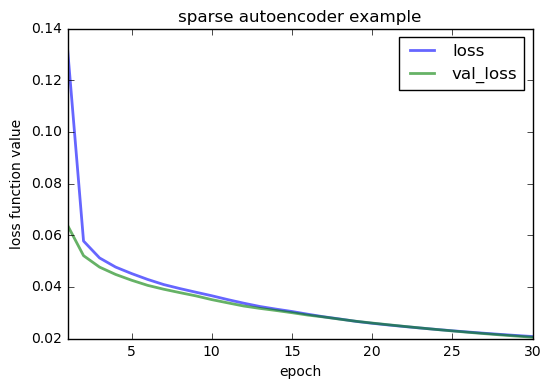

In [16]:
import pandas as pd
random_state = 1234

windowTrain=GetWindowFrame('AccX',Sensor1['AccX'],256,256/8,WindowDataPath)

x_train = windowTrain
x_valid = windowTrain

n_visible = x_train.shape[1]
n_hidden = 256
rng = np.random.RandomState(random_state)

sa = SA(rng, n_visible=n_visible, n_hidden=n_hidden, sparse_reg=1e-3, optimizer=Adam)
hist = sa.fit(x_train, x_valid, n_epoch=30)

df = pd.DataFrame(hist)
df.index += 1
df.index.name = "epoch"

df[["loss", "val_loss"]].plot(linewidth=2, alpha=0.6)
plt.ylabel("loss function value")
plt.title("sparse autoencoder example")
plt.show()